# Analysis of Tweets

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="darkgrid")

First, read all the files belonging to the followers and group them by id to sum their counts and apply some pre-processing

In [2]:
df = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob('./data/*_tweets.csv')], ignore_index=False)

# Translate the timestamp from a string to a datetime object
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ").dt.tz_localize("UTC").dt.tz_convert("America/Mexico_City")
# Remove tweets that arent mine
df = df.drop(df[df["is_mine"] == 0].index)
# Store weekdays
df["weekday"] = df["timestamp"].dt.day_name()
# Store hour of the day
df["hour"] = df["timestamp"].dt.hour + df["timestamp"].dt.minute/60
# Add a sum of engangements
df["total"] = df["quote_count"] + df["reply_count"] + df["retweet_count"] + df["like_count"]
# make data anonymous
df = df.reset_index().drop(columns=["id"])
df

,timestamp,is_mine,quote_count,reply_count,retweet_count,like_count,weekday,hour,total
0,2021-07-31 23:57:03-05:00,1,0,4,0,0,Saturday,23.950000,4
1,2021-07-31 23:21:52-05:00,1,0,1,0,2,Saturday,23.350000,3
2,2021-07-31 23:08:55-05:00,1,0,1,0,1,Saturday,23.133333,2
3,2021-07-31 23:01:39-05:00,1,0,1,0,2,Saturday,23.016667,3
4,2021-07-31 22:47:45-05:00,1,0,2,0,2,Saturday,22.783333,4
...,...,...,...,...,...,...,...,...,...
1043,2021-02-02 07:26:32-06:00,1,0,0,0,2,Tuesday,7.433333,2
1044,2021-02-02 00:59:22-06:00,1,0,0,0,2,Tuesday,0.983333,2
1045,2021-02-02 00:06:58-06:00,1,0,1,0,2,Tuesday,0.100000,3
1046,2021-02-01 23:13:35-06:00,1,0,0,0,7,Monday,23.216667,7


First, plot the cummulative amount of my tweets just for reference

In [4]:
in_time = df[df["is_mine"]==1].set_index("timestamp")
in_time.sort_index(inplace=True)
in_time["cum_like"] = in_time["like_count"].cumsum()
in_time["cum_retweet"] = in_time["retweet_count"].cumsum()
in_time["cum_reply"] = in_time["reply_count"].cumsum()
in_time["cum_quote"] = in_time["quote_count"].cumsum()
in_time["cum_total"] = in_time["total"].cumsum()

Text(0, 0.5, 'Cummulative Interactions')

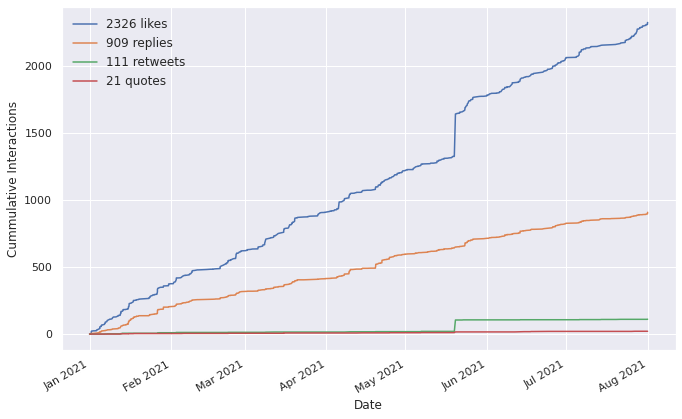

In [5]:
from matplotlib import dates

fig, ax = plt.subplots(figsize=(11,7))

in_time["cum_like"].plot(label=f"{in_time['cum_like'].max()} likes",ax=ax)
in_time["cum_reply"].plot(label=f"{in_time['cum_reply'].max()} replies",ax=ax)
in_time["cum_retweet"].plot(label=f"{in_time['cum_retweet'].max()} retweets",ax=ax)
in_time["cum_quote"].plot(label=f"{in_time['cum_quote'].max()} quotes",ax=ax)
ax.legend(fontsize=12,frameon=False)
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))
ax.set_xlabel("Date")
ax.set_ylabel("Cummulative Interactions")

## Which day do I tweet the most?
After looking at the graph, we see that I tend to tweet less on Wednesdays

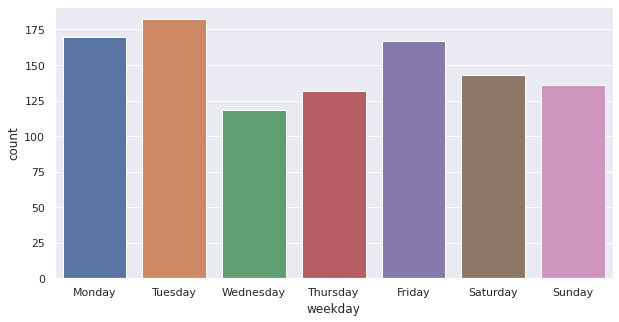

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
_ = sns.countplot(x="weekday", data=df, order=weekdays, ax=ax)

## At what hour do I tweet the most?

* Most of the times I am asleep from 3 to 8, but when I stay up late, I tend to still tweet at 2pm
* I don't like the mornings, so I am usually still sleeping until 10am, so that's when my activity starts
* I am usually on my workout from 7pm to 8pm, which explains why I almost never tweet at that time

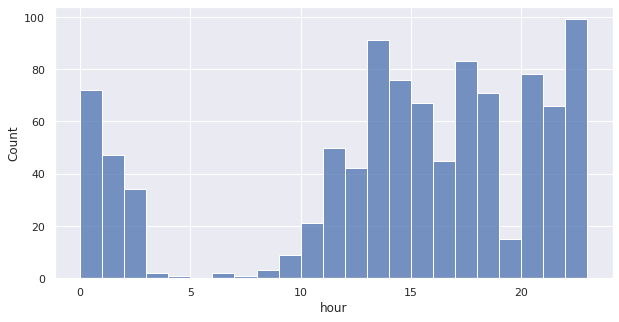

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
_ = sns.histplot(x="hour", data=df, bins=np.arange(0,24,1), ax=ax)

See how the distributions look by shifting times between 0 and 5 to count as the night of the previous day.

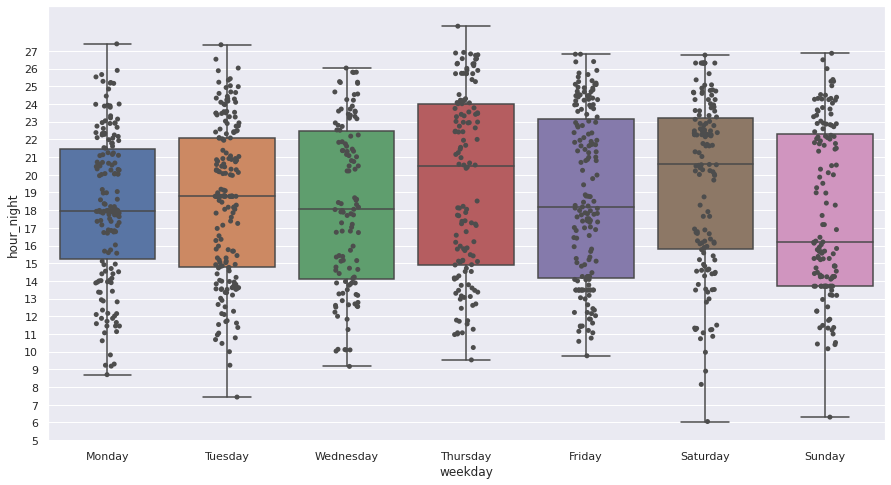

In [8]:
# Filter
df["hour_night"] = df["hour"].apply(lambda hour : hour if hour >= 5 else hour+24)
# Plot
fig, ax = plt.subplots(figsize=(15,8))
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_yticks(np.arange(0,28,1), minor=False)
_ = sns.boxplot(x="weekday", y="hour_night", data=df, order=weekdays, ax=ax)
_ = sns.stripplot(x="weekday", y="hour_night", data=df, order=weekdays, color=".3", ax=ax)

We see no outliers. Let's now split the distributions to see the main hours during the morning and during the afternoon

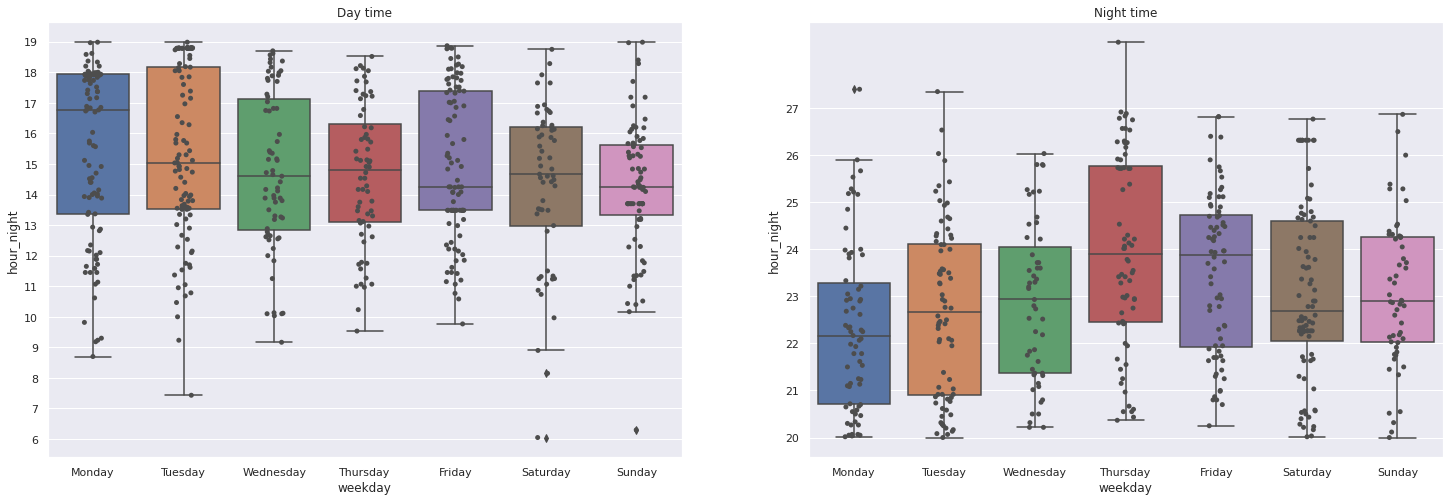

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(25,8))
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot the data during the day
ax = axs[0]
daytime = df[(df["hour_night"] < 19)]
ax.set_yticks(np.arange(0,24,1), minor=False)
ax.set_title("Day time")
_ = sns.boxplot(x="weekday", y="hour_night", data=daytime, order=weekdays, ax=ax)
_ = sns.stripplot(x="weekday", y="hour_night", data=daytime, order=weekdays, color=".3", ax=ax)

# Plot the data during the night and fix times after 12pm
ax = axs[1]
nightime = df[(df["hour_night"] >= 20)].copy()
ax.set_yticks(np.arange(0,28,1), minor=False)
ax.set_title("Night time")
_ = sns.boxplot(x="weekday", y="hour_night", data=nightime, order=weekdays, ax=ax)
_ = sns.stripplot(x="weekday", y="hour_night", data=nightime, order=weekdays, color=".3", ax=ax)

Some conclusions:

During the day:
* On Mondays I tend to tweet at 5pm
* The rest of the days is uniform between 2-3pm.

During the night:
* Thursday and Fridays I tweet more around midnight
* The rest of the days is slightly earlier between 10pm and 11pm

# At what time should I tweet the most?
Check how many engagements (in total, likes, RTs, quotes and replies) I get at every hour

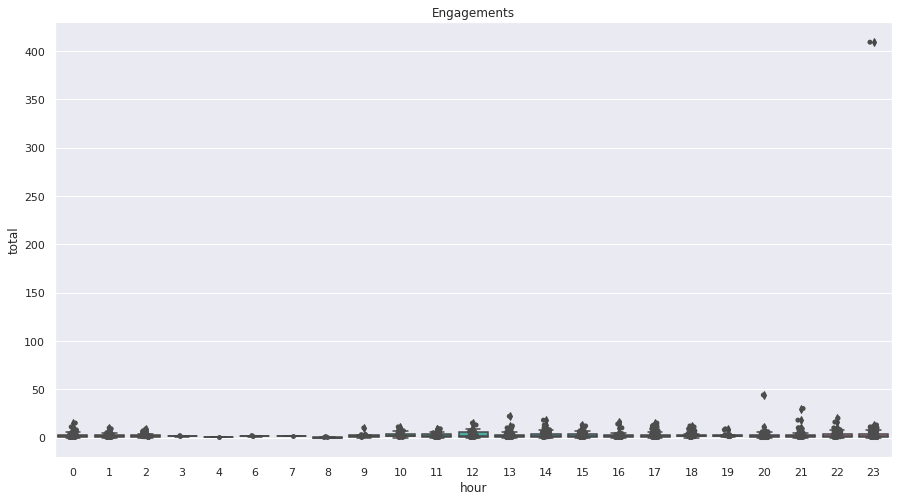

In [10]:
integer_hours = df.copy()
integer_hours["hour"] = integer_hours["hour"].apply(lambda h : int(h))

# Plot the amounto of engagements
fig, axs = plt.subplots(1, 1, figsize=(15,8))
ax = axs
ax.set_xticks(np.arange(0,24,1), minor=False)
ax.set_title("Engagements")
_ = sns.boxplot(x="hour", y="total", data=integer_hours, ax=ax)
_ = sns.stripplot(x="hour", y="total", data=integer_hours, color=".3", ax=ax)

Let's remove the outliers with the IQR method

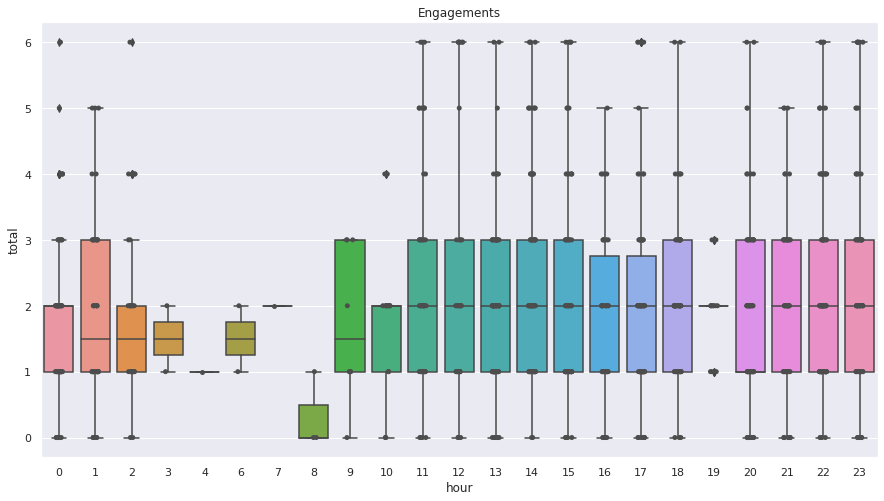

In [11]:
def find_outliers_limit(df, col, z=1.5):
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    cut_off = iqr * z
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower,upper

def get_outliers_filter(data, col):
    lower, upper = find_outliers_limit(data, col)
    return (data[col] < lower) | (data[col] > upper)

outlier_cols=["total"]
for col in outlier_cols:
    integer_hours = integer_hours[ ~get_outliers_filter(df,col) ]

# Plot the amounto of engagements
fig, axs = plt.subplots(1, 1, figsize=(15,8))
ax = axs
ax.set_xticks(np.arange(0,24,1), minor=False)
ax.set_title("Engagements")
_ = sns.boxplot(x="hour", y="total", data=integer_hours, ax=ax)
_ = sns.stripplot(x="hour", y="total", data=integer_hours, color=".3", ax=ax)

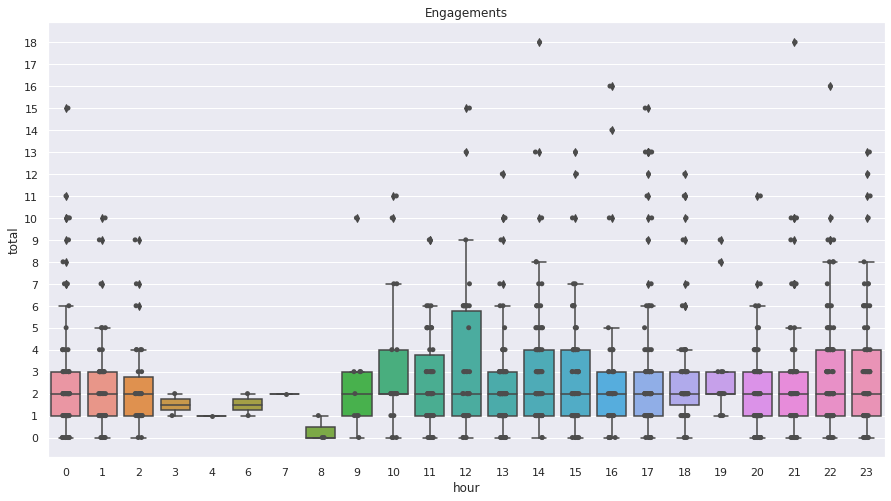

In [12]:
without_outliers = df[df["total"] < 20]

integer_hours = without_outliers.copy()
integer_hours["hour"] = integer_hours["hour"].apply(lambda h : int(h))

# Plot the amounto of engagements
fig, axs = plt.subplots(1, 1, figsize=(15,8))
ax = axs
ax.set_xticks(np.arange(0,24,1), minor=False)
ax.set_yticks(np.arange(0,20,1), minor=False)
ax.set_title("Engagements")
_ = sns.boxplot(x="hour", y="total", data=integer_hours, ax=ax)
_ = sns.stripplot(x="hour", y="total", data=integer_hours, color=".3", ax=ax)

There is no clear trend. Let's split in weekdays and weekends to see what happes

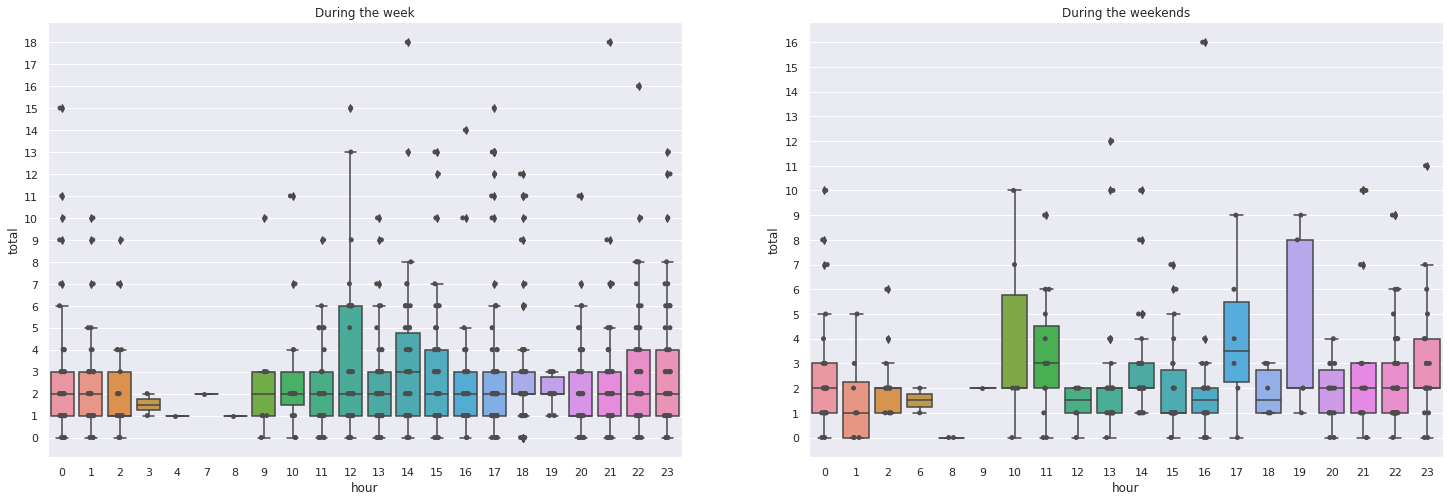

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(25,8))
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekends = ["Saturday", "Sunday"]

# Plot the data during the week
ax = axs[0]
on_week = integer_hours[(integer_hours["weekday"].isin(weekdays))].copy()
on_week["hour"] = on_week["hour"].apply(lambda h : int(h))
ax.set_yticks(np.arange(0,20,1), minor=False)
ax.set_title("During the week")
_ = sns.boxplot(x="hour", y="total", data=on_week, ax=ax)
_ = sns.stripplot(x="hour", y="total", data=on_week, color=".3", ax=ax)

# Plot the data during the weekend
ax = axs[1]
on_weekend = integer_hours[(integer_hours["weekday"].isin(weekends))].copy()
on_weekend["hour"] = on_weekend["hour"].apply(lambda h : int(h))
ax.set_yticks(np.arange(0,20,1), minor=False)
ax.set_title("During the weekends")
_ = sns.boxplot(x="hour", y="total", data=on_weekend, ax=ax)
_ = sns.stripplot(x="hour", y="total", data=on_weekend, color=".3", ax=ax)

It seems that 12, 2 and 3 are good hours